# Chapter 3 Classification

Will be using the **MNIST** dataset, 70,000 small images of digital hand written digits.

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

`sklearn.datasets` contains mostly 3 types of functions
- fetch_* such as fetch_openml() downloads real life datasets
- load_* loads small toy datasets
- make_8 generates fake datasets useful for tests

Generated datasets usually returned as `(X,y)` typle. Containing input data and targets, both as Numpy Arrays

Sometimes others are returned as `sklearn.utils.Bunch` objects, which are dictionaries with the following entries:
- "DESCR" - description of dataset
- "Data" - Input data, usually as 2D numpy array
- "targeet" - Labels, usually as 1D numpy array

**However** fetch_openml() by dafault returns inputs as Pandas DataFrame and labels as Pandas Series (unless the data is sparse). MNIST contains images so dataframes are not ideal. We set `as_frame=False` to get np array.

In [4]:
# lets look at the data
X, y = mnist.data, mnist.target

print(X)
print(X.shape)
print(y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(70000, 784)
(70000,)


We can see that there are 70k images, each image having 784 (24px * 24px) features.

Each feature is pixel intensity from 0 (white) -> 255 (black)

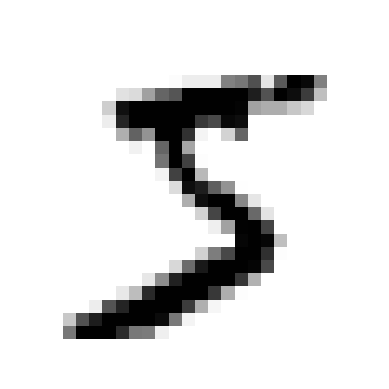

4


In [5]:
#Lets take a look at one dataset
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()
#Label:
print(y[2])

Should create test set and set aside, however the MNIST dataset returned is already split into training and test. 

Training first 60k images, test last 10k images.

Training set already shuffled.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


### Training a Binary Classifier

The 5 detector (Binary classifier)

In [7]:
#Create the target vectors:
y_train_5 = (y_train == '5') 
y_test_5 = (y_test == '5')

Then we choose a classifier and train it.

Good place to start is with stochastic gradient descent. Use sklearn's SGDClassifier class. Can handle large datasets efficiently. Well suited for online learning.

In [8]:
# Training model, takes ~ 15 seconds to run
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [9]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures
Evaluation of classifier signficantly trickier than evaluating a regressor.

Many perfromance measures

**Measuring Accuracy using Cross Validation**
Use `cross_val_score()` fcn to evaluate `SGDClassifier`. Will use k-fold cross validation.

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Looks pretty good, but lets look at a dummy classifier that classifies every image in the most frequent class eg non-5's

In [11]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # Prints false, no fives detected

# What is the accuracy?

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

False


array([0.90965, 0.90965, 0.90965])

So a dummy classifier is also pretty good? Why?

Because only about 10% of images are 5s, image that are not 5's have a 90% change of being right.

**Shows** that accuraccy is not the preferred metric for classifiers especially with skewed datasets (when some classes are much more frequent than others).

### Confusion Matrix (CM)
Count the number of times instances of Class A are classified as Class B for all A/B paris.

Eg. To know the number of times classifier confused 8s with 0s, would look at row 8 and column 0 of confusion matrix

To compute, need to first have a set of predictions so that they can be compared to the actual target.

Can make predicitons of test set, but keep it untouched for now, we only use test sets at the very end of project once classifier is ready to launch.

Use the cross_val_predict() function:

In [12]:
from sklearn.model_selection import cross_val_predict
# Just like cross_val_score, but instead of returning scores, it returns
# predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in the matrix represents an actual class
Columns represents predicted class.

First row considers non-5 images (negative class). 53892 correctly classified (true negatives), while 687 were not (false positive)

Second row considers 5s images (positive class): 1891 wrongly classified as non 5s (false negative), remaining 3530 correctly classified (true postives)

**Consise Metrics**

$$\text{precision} = \frac{TP}{TP + FP}$$

$$\text{recall} = \frac{TP}{TP + FN}$$

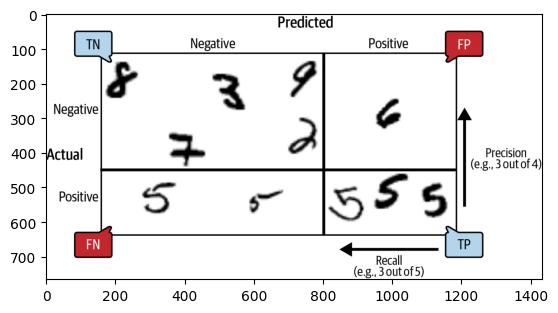

In [14]:
import matplotlib.image as mpimg
img = mpimg.imread("002Metric.png");
plt.imshow(img)
plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score

print("Precision", precision_score(y_train_5, y_train_pred))
print("Recall", recall_score(y_train_5, y_train_pred))

Precision 0.8370879772350012
Recall 0.6511713705958311


Now we can see that our 5 detector isn't too good as if we only had looked at its accuracy. When it claims a 5, it is correct 83% of the time.

But in total amount of 5's, it only detects 65.1% of them.

**EVEN MORE CONCISE**, combine them into a $F_1$ score.

It is the harmonic mean of precision and recall. Gives much more weight to low values, will only get a high score if both are high.

However, f_1 scores favor classifiers with similar precision and recall, and depending on your situation, you might be fine or want a higher precision or recall score. They are trade offs.

In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

### The precision / Recall trade-off
- Classfication computes a score based on a decision function.
- If a score is greater than some threshold, it assigns the instance to a positive class, otherwise it is a negative class.
- By modifying a threshold, you either allow more false positives or make it more strict and have more false negatives.

<img src="002Tradeoff.png" height="200" />


Using classifier's `decision_function()` method returns score for each instance. Then can use any threshold to make predictions based on the scores.

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0

y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# Lets make the threshold bigger
print("Bigger Threshold")
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
# Can see that increasing threshold decreased recall, image is a 5 but classifier
# misses it when threshold is increased.

[2164.22030239]
[ True]
Bigger Threshold
[False]


To decide which threshold to use, use the `cross_val_predict()` function to get scores of all instances in training set. This time, speciify you want to return scores instead of predictions.

In [18]:
# Takes ~ 20sec to run
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5,
                             method="decision_function", cv=3)

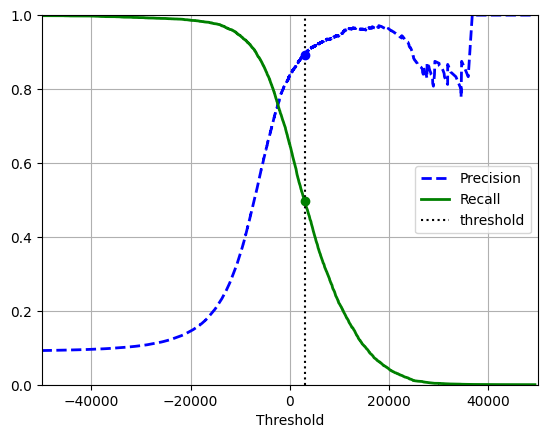

In [19]:
#Plot precision and recall vs threshold value

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

Or an plot precision directly against recall

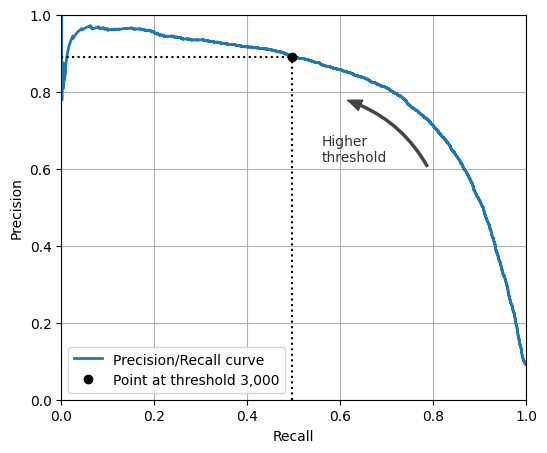

In [20]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Can see precision drops sharply at ~80% recall, would want to select a tradeoff just before the drop.

Lets say we want 90% precision, can search for lowest threshold that gives at least 90% precision.

In [21]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)

3370.0194991441826


In [22]:
# Then make predictions (training set), instead of calling .predict(), 
# can run this code

y_train_pred_90 = (y_scores >= threshold_for_90_precision)

print(precision_score(y_train_5, y_train_pred_90))

recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.9000345901072293


0.4799852425751706

We now have a 90% precision classifer, however 48% recall is not great.

With scikit, we can use two classes to easily adjust decision threshold:
- `FixedThresholdClassifer` lets you wrap a binary classifer and set threshold manually. If underlying classifer has a `precict_proba()` method, set threhsold between 0-1. Otherwise, decision score comporable to output of model's `decision_function()` where the default is 0.
- `TunedThresholdClssiverCV` uses k-fold cross validation to automatically find optimal threshold given a metric. It tries to maximize balanced accuracy (average of each class's recall), but can select another metric to optimize for (documentation)

### The ROC Curve
Receiver Operating Characteristic is another common tool with binary classifers

Instead of plotting precision vs recall, plots true postive rate against false postive rate (FPR) - Fall-out.

It is the ratio of negative instaces incorrectly classified as positive.

Equals 1 minus the true negative rate (TNR) , the ratio of negative instances that are correctly classified as negative. TNR is also known as specificity.

ROC curve plots sensitivity (recall) versus 1-specificity.

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


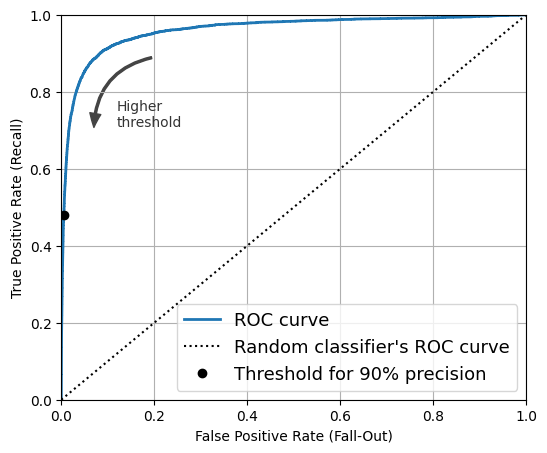

In [24]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

Lets find PR curve and F1 score of RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

#precsion_recall_curve() expects labels and scores for eac instance
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")


array([[0.11, 0.89],
       [0.98, 0.02]])

In [ ]:
# can see the first image has is positive with 89%
# predicts second image is negative 99%
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

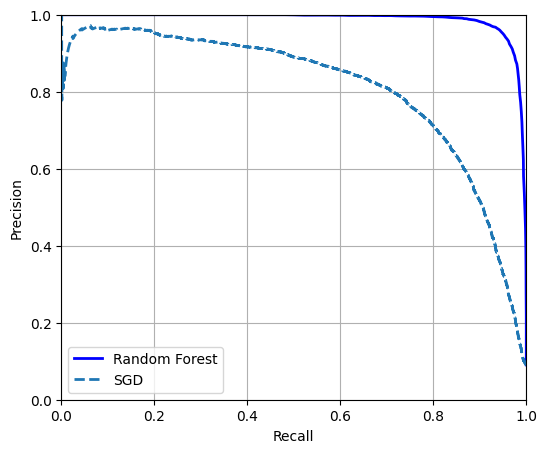

In [30]:
# second col contains estimated probabilities for positve class
# pass them to precision_recall_curve
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, threshold_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Can see RandomForestClassifier PR curve looks better than SGDClassifier's

In [ ]:
from sklearn.metrics import roc_auc_score
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%

print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))

# Looks pretty good

0.9270445185330457
0.9983296721818179


### Multiclass Classification
Distinguish between more than two classes.

Can classify images into 10 classes 0-9 and train 10 binary classifier, one for each digit.
- And when you want to classify an image, get decision score from each image and choose the highest score. Called one-versus-the-rest (OvR) of one vs all (OvA)

Or train every classifier for every pair of digis, 0-1, 0-2, another for 1s and 2s etc. called one-versus-one (OvO) strategy. if there are N classes, need to train $N \times (N-1)/2$ classifiers.

Some algorithms scale poorly with size of training set such as support vector machine classifiers.

OvO preferred to train many classifiers on small training sets than few classifiers on large training sets.

However for most binary classification algorithms, ovr is preferred.

Sklearn will automatically run OvR or OvO depending on algorithm

In [ ]:
# lets try SVC
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
#Only the first 2000 or it takes a long time
svm_clf.fit(X_train[:2000], y_train[:2000])

#Correct
print(svm_clf.predict([some_digit]))

some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores.round(2))
# Highest score is 9.3, which corresponds to class 5

['5']
[[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]


In [38]:
# When classifier trained, stores list of target classes in classes_ attr.
class_id = some_digit_scores.argmax()
print(svm_clf.classes_)

svm_clf.classes_[class_id]

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


'5'

In [40]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [44]:
#SGD on multi-class dataset
# Takes a while
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [46]:
sgd_clf.predict([some_digit])
# Not right prediction, 10 classes = 10 trained binary classifiers.
# Returns 1 value per class
print(sgd_clf.decision_function([some_digit]).round())
# Can see not very confident about predictions, scores are very negative.

#Lets validate it on more than one image
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# Can see it gets pretty good accuracy

[[-31893. -19048.  -9531.   1824. -22320.  -1386. -26189. -16148.  -4604.
  -12051.]]


array([0.87745, 0.85835, 0.8698 ])

In [47]:
# Scale the inputs, get better accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/jackychen/Desktop/HandsONMachineLearn/.venv/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/jackychen/Desktop/HandsONMachineLearn/.venv/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


KeyboardInterrupt: 